# **Computer Vision Project - Plant Seeding Classification**

**Context**

To modernize the field of agriculture and reduce the extensive labor work, Artificial Intelligence and Deep Learning can help the workers in this field by shortening the time and energy required to identify plant seedlings. The ability to do so far more efficiently and even more effectively than experienced manual labor could lead to better crop yields, the freeing up of human involvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.

**Objective**

University has provided the data containing images of unique plants belonging to 12 different species. The objective is to build a Convolutional Neural Network model which would classify the plant seedlings into their respective 12 categories.

**Data Discription**

This dataset contains images of unique plants belonging to 12 different species.

**List of Plant species**

Black-grass

Charlock

Cleavers

Common Chickweed

Common Wheat

Fat Hen

Loose Silky-bent

Maize

Scentless Mayweed

Shepherds Purse

Small-flowered Cranesbill

Sugar beet

# **1. Loading Required Libraries and Importing Data**

In [ ]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


As there are 2 files (images and labels) to load, let's load them separately. 

In [ ]:
# Loading images file
images=np.load('/content/drive/My Drive/Colab Notebooks/images.npy' )

In [ ]:
# Loading labels file
labels = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Labels.csv')

# **2. Exploring Data At High Level**

As dataset is loaded into 2 files, Let's check the shape of these. 

In [ ]:
# checking shape of images
images.shape

(4750, 128, 128, 3)

In [ ]:
# checking shape of labels
labels.shape

(4750, 1)

There are total 4750 images in the dataset. All images are 128 X 128 and having 3 channels, Red, Green and Blue. 

As the images were converted to numpy arrays already so let's plot an image randomly using OpenCV and matplotlib and see how the RGB is defined.

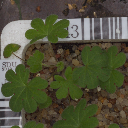

In [ ]:
# loading image 3 using OpenCV (cv2_imshow)
cv2_imshow(images[3])

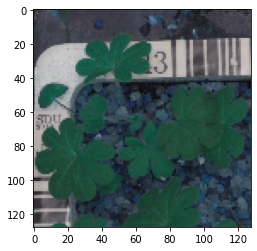

In [ ]:
# loading image 3 using matplotlib (plt)
plt.imshow(images[3])

As we can see that the images are being shown in different colors when plotted with OpenCV and matplotlib as OpenCV reads images in BGR format and this shows that the given numpy arrays were generated from the original images using OpenCV.

For standard practice, we should convert these BGR images to RGB images so we could interpret them easily.

In [ ]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

Let's check the same image one more time using matplotlib to make sure it worked.

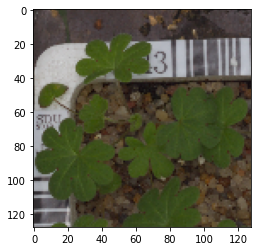

In [ ]:
# loading image 3 using matplotlib (plt)
plt.imshow(images[3])

Looks good.

Let's plot 1 image from each class, just to get an idea how they look. 

For that, I will like to create a function to pick random images and plot 1 image from each class. 

In [ ]:
# creating a function to create image from each class.
def unique_plot_images(images,labels):
  num_classes=12                                                                     # Number of Classes                                                 
  categories=np.unique(labels)                                                       
  keys=dict(labels['Label'])                                                      
  rows = 3                                                                           # setting rows and columns to plot 12 different unique class images
  cols = 4           
  lst=[]                                                                             # creating empty list to check if the class has been previously used or not. 
  fig = plt.figure(figsize=(18, 10))    
  k = 1
  i=0
  j=-1
  while k <= num_classes:
    random_index = np.random.randint(0, len(labels))                                # Generating random indices from the data and plotting the images
    if keys[random_index] not in lst:
        lst.append(keys[random_index])
        if j==2:
          i+=1
          j=0
        else:
          j+=1
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)                         # Adding subplots with 3 rows and 4 columns
        ax.imshow(images[random_index, :])                                       
        ax.set_title(keys[random_index])
        k+=1
    else:
      pass
  plt.show()                                                                      # Plotting the image 
  

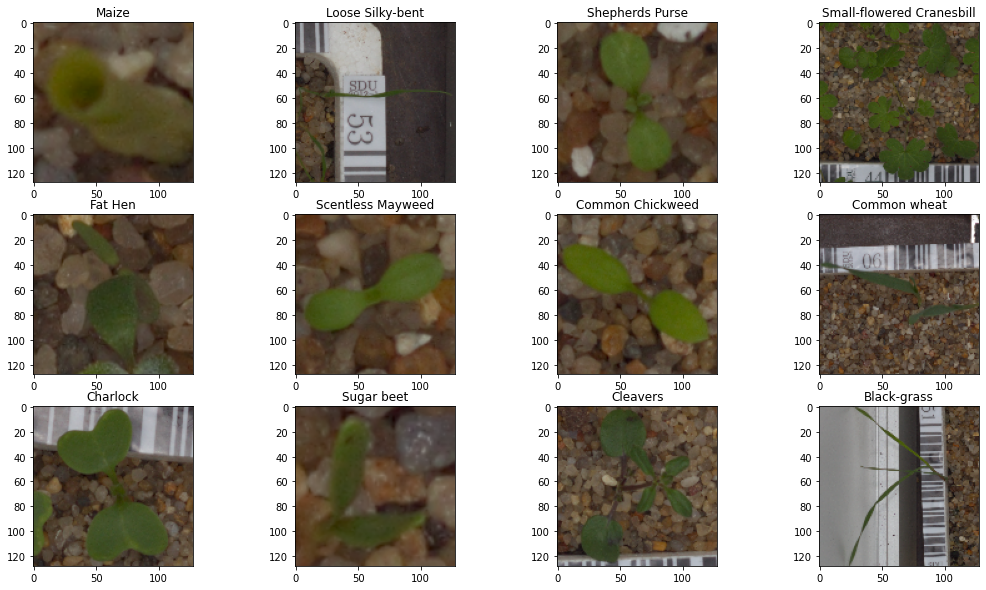

In [ ]:
# call the function to see the images from each class
unique_plot_images(images,labels)

Looks good, we can see image from each class. Some species look very close to each other, like Scentless Mayweek and Common Chickweed, Common Wheat and Black Grass. Let's see how well models can identify those in later sections. Next, let's do EDA. 

# **3. Exploratory Data Analysis (EDA)**

To do EDA, let's create another function to plot random 30 images from the dataset. Just to get idea how different they look. 

For that, I would like to create similar function like before but rather than selecting 1 image from each class, I will plot images randomly from each class as I would like to more than 1 image from classes. 

In [ ]:
def plot_images(images,labels):
  num_classes=12                                                                  # Number of Classes
  categories=np.unique(labels)   
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 5                                                                        # Defining number of rows=3
  cols = 5                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(18, 10))                                               # Defining the figure size to 18x10
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image 
          ax.set_title(keys[random_index])
  plt.show()

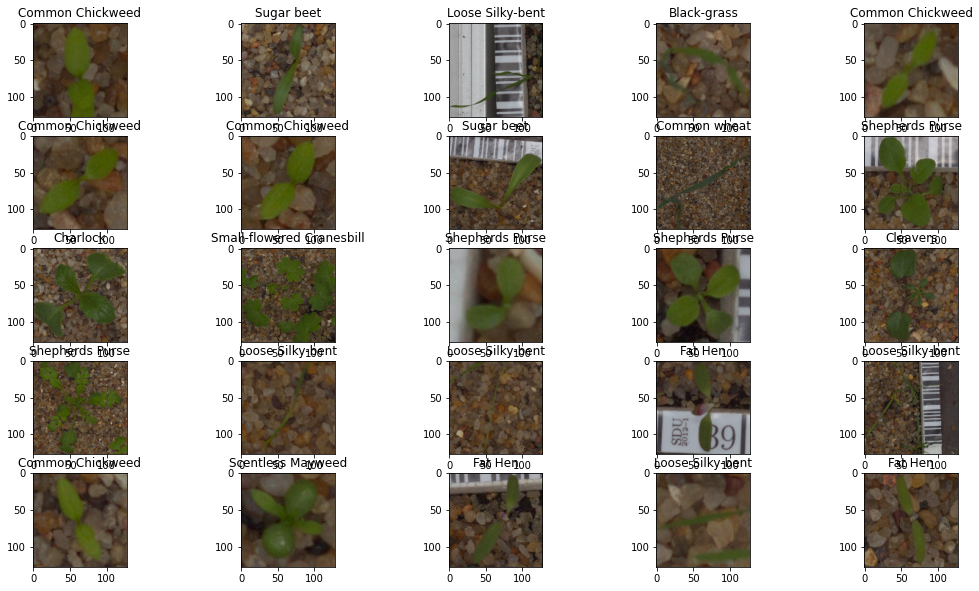

In [ ]:
plot_images(images,labels)

Few observations - 

1) Few images have some kind of scale next to it and some do not. Because of this scale, it's hard to differentiate the actual plant (for ex - see image 3 in first row). Sclae next to plant is a noise in the image will be hard for model to remove that. 

2) Not all images have similar backgroup. Some has small pebles, some has big ones. Also, previously we saw some black background also. 

3) Few images look blurred also and some don't. We will try gaussian blur later to check more. 

4) In few images, plant takes whole size of an image and in few, it takes very small part of whole image.

Next, need to check balance in data for all 12 classes. For that, let's plot count of records by each class.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

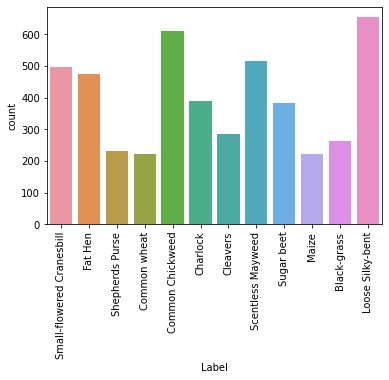

In [ ]:
# plotting the graph of counts of each class
sns.countplot(labels['Label'])
plt.xticks(rotation='vertical')

Data looks imbalanced visually. Let's print some numbers and percentages.

In [ ]:
# count and % of each class
count=labels.Label.value_counts()
print(count)
print('*'*10)
count=labels.Label.value_counts(normalize=True)
print(count)

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: Label, dtype: int64
**********
Loose Silky-bent             0.137684
Common Chickweed             0.128632
Scentless Mayweed            0.108632
Small-flowered Cranesbill    0.104421
Fat Hen                      0.100000
Charlock                     0.082105
Sugar beet                   0.081053
Cleavers                     0.060421
Black-grass                  0.055368
Shepherds Purse              0.048632
Common wheat                 0.046526
Maize                        0.046526
Name: Label, dtype: float64


Classes like 'Loose Silky-bent' and 'Common Chickenweed' have almost 3 times more data compare to classes like 'Maize', 'Common wheat'.

Later in the project, once the data is split between train and test, I would like to determine the weightage of each and apply that while fitting into the model to keep it fair across all classes.

# **4. Data Pre-Processing**

**Resizing**

As seen earlier, all the images are 128 x 128 and have 3 channels. It would required lot of computation and would take longer to train model. I would like to resize the images to half (64x64) and check it out. 

In [ ]:
# create a new dataset with reduced size of 64x64
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)  
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

Let's check the same image#3 that we checked earlier. Plot both - before and after to check.

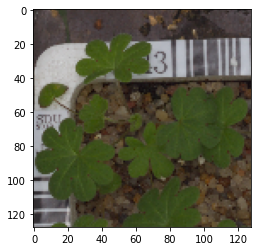

In [ ]:
# before reducing the size
plt.imshow(images[3])

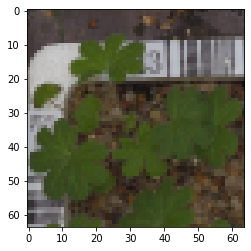

In [ ]:
# after reducing the size
plt.imshow(images_decreased[3])

Image looks bit blurred after resizing but still its easily identifiable. I will continue with this size.

**Gaussian Blurring**

Next, let's try Gaussian Blurring to reduce the noise in the images. I would like to try that on top of decreased size images. 

In [ ]:
# Applying Gaussian Blur to denoise the images
images_gb=[]
for i in range(len(images_decreased)):
  # gb[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
  images_gb.append(cv2.GaussianBlur(images_decreased[i], ksize =(3,3),sigmaX =  0))

Let's plot before and after images of image#3.

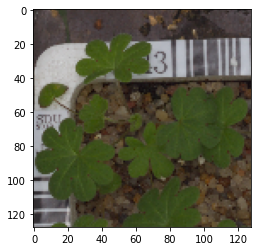

In [ ]:
# plotting original image
plt.imshow(images[3])

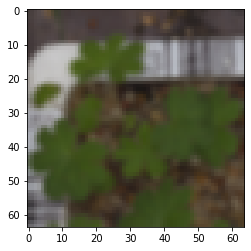

In [ ]:
# plotting gaussian blur image after resizing
plt.imshow(images_gb[3])

The above image is less in size and removed some noise, I would like to train models on these, which will help with computation and also have less noise compare to original images.

**Splitting the data**

I would like to split the data in train, validation and test. First take 10% data out for test and then 10% for validation from the remaining images.

In [ ]:
# splitting the data to 0.1 for test and then 0.1 for validation from remaining data. 
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_gb),labels , test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)

Let's check the size of each datasets.

In [ ]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


Training got 3847 records, validation got 428 and 475 for test. Not much data to train but let's see how the models perform in later sections. 

**Class Balancing**

During EDA, we saw the imbalance in data across different classes. Let's create class weights for each class to use it while fitting the model. I would like to do that on training data only.

In [ ]:
from sklearn.utils import class_weight

labelList = labels.Label.unique()
class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                  classes = np.array(labelList),
                                                  y = y_train.values.reshape(-1)
                                                  )
class_weights = dict(zip(np.array(range(len(labelList))), class_weights))
#print calculated class weights
class_weights

{0: 0.7974709784411277,
 1: 0.8348524305555556,
 2: 1.714349376114082,
 3: 1.7909683426443204,
 4: 0.6476430976430977,
 5: 1.0145042194092826,
 6: 1.3818247126436782,
 7: 0.7669457735247209,
 8: 1.0275106837606838,
 9: 1.7909683426443204,
 10: 1.5050860719874803,
 11: 0.604874213836478}

Above shows the weight of each class. 

**Encoding**

Next, let's encode the target variables using one hot vectors using Labelbinarizer. 

In [ ]:
# Convert labels from names to one hot vectors.
# We have already used encoding methods like onehotencoder and labelencoder earlier so now we will be using a new encoding method called labelBinarizer.
# Labelbinarizer works similar to onehotencoder 

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

We have created '_encoded' version of each target dataset (train, validation, test) and will be using those in the models. 

**Data normalization**

Image pixel values range from 0 to 255, so to normalize the data, let's divide those by 255 so the values will become between 0 and 1.

In [ ]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

We have created '_normalized' version of each image datasets (train, validation, test) and will be using those in the models.

Let's check the shape of normalized and encoded datasets that we created, they should be compatible with keras models.

In [ ]:
print(X_train_normalized.shape,y_train_encoded.shape)
print(X_val_normalized.shape,y_val_encoded.shape)
print(X_test_normalized.shape,y_test_encoded.shape)

(3847, 64, 64, 3) (3847, 12)
(428, 64, 64, 3) (428, 12)
(475, 64, 64, 3) (475, 12)


Looks good for keras modeling. In Keras, The input features are 4-dimensional for a Conv2D layer. Here, we already have 4-dimensional input as these are colored images.

Before we start the modeling, let's plot few random images on the final processed datasets. We already have the before images. 

To plot images after the processing steps, I would like to create a function that would plot those images.

In [ ]:
# function to create final processed images
def final_plot_images(images,labels):
  num_classes=12                                                                  # Number of Classes
  categories=np.unique(labels)   
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(18, 10))                                               # Defining the figure size to 18x10
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                       
          ax.set_title(labels[random_index])
  plt.show()                                                                      # Plotting the image

Plotting the images from train datasets.

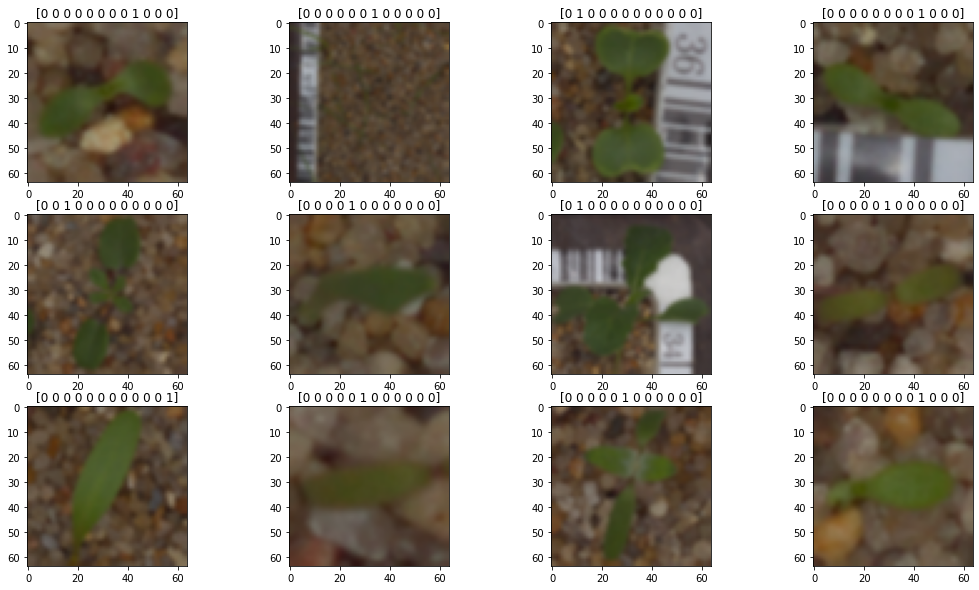

In [ ]:
final_plot_images(X_train_normalized,y_train_encoded)

Plotting the images from validation datasets.

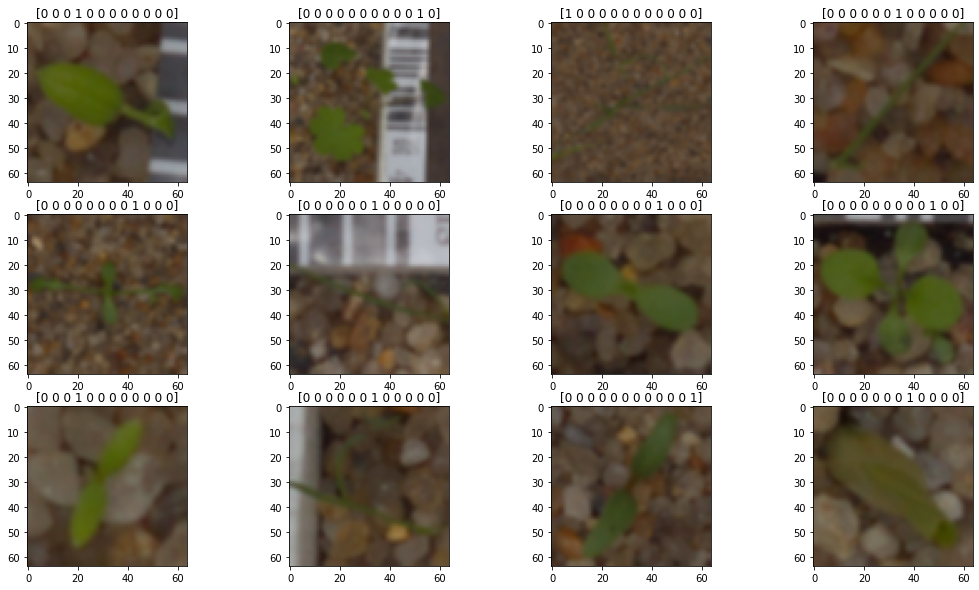

In [ ]:
final_plot_images(X_val_normalized,y_val_encoded)

Plotting the images from test datasets.

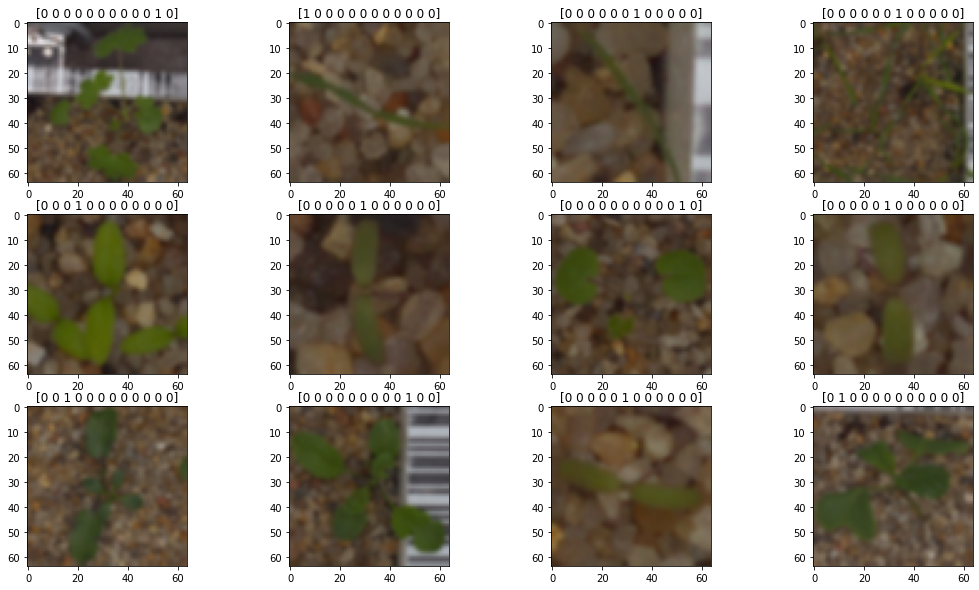

In [ ]:
final_plot_images(X_test_normalized,y_test_encoded)

All loook good. Let's start the modeling. 

# **5. Model Building - Convolution Neural Network**

As part of this section, we will build different kind of CNN models. To start with, will build basic one and then build one with data augmentation, transfer learning etc and see we can improve the accuracy. At last, we will compare all the models. 

##**Model 1 - Basic**

In the first model, will build feature extraction layers with different convolutional and pooling layers. It will have padding as 'SAME' to keep the same size of output as input. The classification layers would be fully connected and add would add dropout also. For this model, I would like to use Adam as optimizer and add accuracy as matrix to measure. 

Before we start, first we need to clear the previous model's history from the session otherwise the previous model history remains in the backend. 

After clearing the backend, let's fix the seed using random number generators in Numpy and in TensorFlow to be able to reproduce the same results every time we run the code. 


In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

# Adding second conv layer with 32 filters and kernel size 3x3 , padding 'same'
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
# Adding another max pooling layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer    
model.add(Dense(16, activation='relu'))
# Adding dropout to randomly switch off 30% neurons to reduce overfitting
model.add(Dropout(0.3))
# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem  
model.add(Dense(12, activation='softmax'))

# Using Adam Optimizer
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 16)                1

Total parameters in above model are 151,548 and all are trainable.

Let's fit the model by applying class weights that were calculated earlier and run for 30 epochs and batch size of 32. 

In [ ]:
mode1_history = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2,
            class_weight=class_weights
)

Epoch 1/30
121/121 - 13s - loss: 2.9446 - accuracy: 0.1113 - val_loss: 2.4743 - val_accuracy: 0.1098 - 13s/epoch - 107ms/step
Epoch 2/30
121/121 - 1s - loss: 2.6848 - accuracy: 0.2098 - val_loss: 2.1619 - val_accuracy: 0.2500 - 808ms/epoch - 7ms/step
Epoch 3/30
121/121 - 1s - loss: 2.4327 - accuracy: 0.2735 - val_loss: 1.9356 - val_accuracy: 0.3481 - 782ms/epoch - 6ms/step
Epoch 4/30
121/121 - 1s - loss: 2.2263 - accuracy: 0.2945 - val_loss: 1.7775 - val_accuracy: 0.3692 - 796ms/epoch - 7ms/step
Epoch 5/30
121/121 - 1s - loss: 2.1442 - accuracy: 0.2950 - val_loss: 1.6702 - val_accuracy: 0.3668 - 793ms/epoch - 7ms/step
Epoch 6/30
121/121 - 1s - loss: 2.0616 - accuracy: 0.3005 - val_loss: 1.6045 - val_accuracy: 0.3855 - 799ms/epoch - 7ms/step
Epoch 7/30
121/121 - 1s - loss: 2.0054 - accuracy: 0.3221 - val_loss: 1.5373 - val_accuracy: 0.4416 - 1s/epoch - 9ms/step
Epoch 8/30
121/121 - 1s - loss: 1.9466 - accuracy: 0.3286 - val_loss: 1.4937 - val_accuracy: 0.4393 - 1s/epoch - 9ms/step
Epoch

Let's build the accuracy graph by epochs.

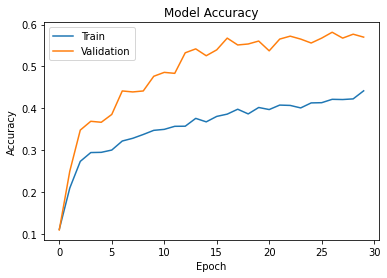

In [ ]:
plt.plot(mode1_history.history['accuracy'])
plt.plot(mode1_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Validation shows better accuracy than training data but it looks overfitting.

Let's check accuracy on Test data also.

In [ ]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 1.2844 - accuracy: 0.5874 - 111ms/epoch - 7ms/step


It is 59% with above model, which is not that great and can be improved. 

Let's generate predictions using test data

In [ ]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

In [ ]:
# checking values of y_pred
y_pred

array([[1.44258303e-08, 1.42791490e-09, 5.22677324e-09, ...,
        4.05254513e-02, 1.59429856e-08, 5.02375944e-04],
       [1.82065666e-13, 4.55645584e-02, 1.29407359e-04, ...,
        1.05048284e-01, 8.20779026e-01, 1.07792737e-02],
       [4.75069484e-10, 1.91250555e-02, 5.55773186e-05, ...,
        1.77709520e-01, 7.28588104e-01, 2.71071829e-02],
       ...,
       [1.47167325e-01, 1.13395538e-06, 1.78468563e-02, ...,
        4.03516879e-07, 7.88377201e-06, 2.37352941e-02],
       [1.28406112e-03, 1.97026471e-04, 2.11243834e-02, ...,
        2.09048256e-01, 5.06619799e-05, 3.25176045e-02],
       [3.86004722e-05, 3.60762030e-02, 2.96684261e-03, ...,
        3.05463284e-01, 2.94937223e-01, 1.06479779e-01]], dtype=float32)

Using y_pred values, we can plot the confusion matrix.

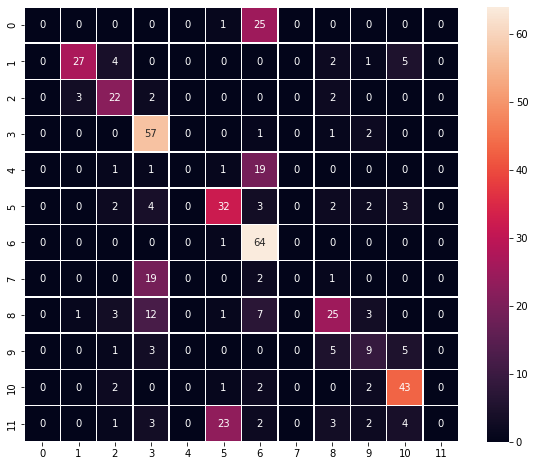

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

Few observations - 

1) Class 3, 6 and 10 were identified for many images. 

2) Class 3 was misclasfied with 7 and 8, Class 5 was misidentified with class 11 and class 6 with class 0 for many images. 

3) Misclassification can be seen multiple times throughout the matrix. We will try to improve it with data augmentation and transfer learning in future models. 

Let's check the other scores like recall, f1, preceision of each class by creating classification report. 

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_arg,y_pred_arg))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.87      0.69      0.77        39
           2       0.61      0.76      0.68        29
           3       0.56      0.93      0.70        61
           4       0.00      0.00      0.00        22
           5       0.53      0.67      0.59        48
           6       0.51      0.98      0.67        65
           7       0.00      0.00      0.00        22
           8       0.61      0.48      0.54        52
           9       0.43      0.39      0.41        23
          10       0.72      0.86      0.78        50
          11       0.00      0.00      0.00        38

    accuracy                           0.59       475
   macro avg       0.40      0.48      0.43       475
weighted avg       0.47      0.59      0.51       475



As seen earlier, test accuracy is 59%. Class 1 has highest precesion and high f1 and recall scores. class 6 has relatively high scores as well. Classes like 0,11 have 0 scores.

##**Model 2 - Using Data Augmentation**

In this section, we will try modeling with data augmentation. It might reduce or get rid of overfitting problem that we saw in previous model. For data augmentation, will try with vertical flip, height shift, width shift, rotation, zoom etc. I will not rescale as all the images are rescaled to 1/255 already.

First clear the previous model's history from the session and fix the seed for same results.

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

Data augmentation using ImageDataGenerator

In [ ]:
# creating datagen by using ImageDataGenerator, it will be used while fitting the model.
train_datagen = ImageDataGenerator(
                              horizontal_flip = True,
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1,
                              fill_mode='nearest'
                              )


In [ ]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

# Adding second conv layer with 32 filters and kernel size 3x3 , padding 'same'
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
# Adding another max pooling layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

# Adding second conv layer with 32 filters and kernel size 3x3 , padding 'same'
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
# Adding another max pooling layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer    
model.add(Dense(16, activation='relu'))
# Adding dropout to randomly switch off 30% neurons to reduce overfitting
model.add(Dropout(0.3))
# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem  
model.add(Dense(12, activation='softmax'))

# Using Adam Optimizer
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 32)        

Total parameters in above model are 62,492 and all are trainable.

Let's fit the model by applying datagen and class weights that were created earlier and run for 30 epochs and batch size of 64. 

In [ ]:
# Epochs
epochs = 30
# Batch size
batch_size = 64

model2_history = model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size, 
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=2,
                    class_weight=class_weights)

Epoch 1/30
60/60 - 5s - loss: 2.9182 - accuracy: 0.1348 - val_loss: 2.4561 - val_accuracy: 0.1379 - 5s/epoch - 81ms/step
Epoch 2/30
60/60 - 4s - loss: 2.8697 - accuracy: 0.1433 - val_loss: 2.4211 - val_accuracy: 0.1706 - 4s/epoch - 67ms/step
Epoch 3/30
60/60 - 4s - loss: 2.6941 - accuracy: 0.2115 - val_loss: 2.1116 - val_accuracy: 0.3364 - 4s/epoch - 69ms/step
Epoch 4/30
60/60 - 4s - loss: 2.3936 - accuracy: 0.2665 - val_loss: 1.9515 - val_accuracy: 0.3388 - 4s/epoch - 67ms/step
Epoch 5/30
60/60 - 4s - loss: 2.2524 - accuracy: 0.2966 - val_loss: 1.8621 - val_accuracy: 0.3621 - 4s/epoch - 68ms/step
Epoch 6/30
60/60 - 4s - loss: 2.1788 - accuracy: 0.3074 - val_loss: 1.7660 - val_accuracy: 0.4089 - 4s/epoch - 66ms/step
Epoch 7/30
60/60 - 4s - loss: 2.0640 - accuracy: 0.3399 - val_loss: 1.6628 - val_accuracy: 0.3972 - 4s/epoch - 66ms/step
Epoch 8/30
60/60 - 4s - loss: 1.9999 - accuracy: 0.3547 - val_loss: 1.6086 - val_accuracy: 0.4065 - 4s/epoch - 67ms/step
Epoch 9/30
60/60 - 4s - loss: 1.

Let's build the accuracy graph by epochs.

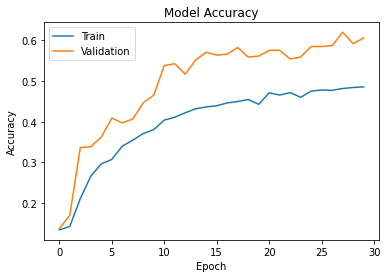

In [ ]:
plt.plot(model2_history.history['accuracy'])
plt.plot(model2_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Accuracy in validation is higher again compare to train and still looks overfit. 

Let's check accuracy on Test data also.

In [ ]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 1.1317 - accuracy: 0.5916 - 201ms/epoch - 13ms/step


Test accuracy is 59%, kind of same compare to previous model.

Let's generate predictions using test data

In [ ]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

Using y_pred values, we can plot the confusion matrix.

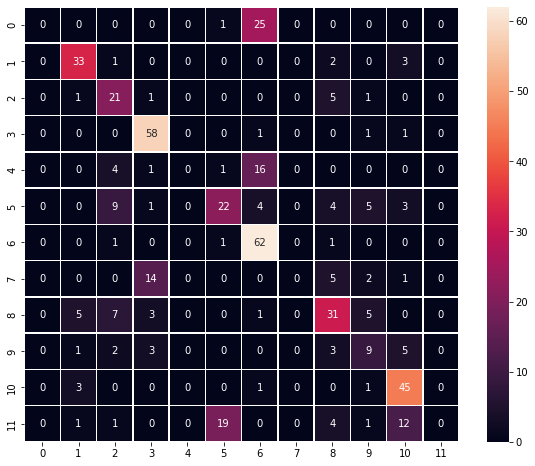

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

Few observations - 

1) Class 3 did much better compare to previous one in misclassification. 

2) Class 6 did many misclassifications with class 0,4 and 5. 

3) Classes like 1 and 8 have improved and did very less misclassification. 

Let's check the other scores like recall, f1, preceision of each class by creating classification report. 

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_arg,y_pred_arg))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.75      0.85      0.80        39
           2       0.46      0.72      0.56        29
           3       0.72      0.95      0.82        61
           4       0.00      0.00      0.00        22
           5       0.50      0.46      0.48        48
           6       0.56      0.95      0.71        65
           7       0.00      0.00      0.00        22
           8       0.56      0.60      0.58        52
           9       0.36      0.39      0.37        23
          10       0.64      0.90      0.75        50
          11       0.00      0.00      0.00        38

    accuracy                           0.59       475
   macro avg       0.38      0.49      0.42       475
weighted avg       0.46      0.59      0.51       475



As seen earlier, test accuracy is 59%. Class 1, 3, 6 and 8 have good scores in all 3 metrics. Class 0,7 and 11 have 0 scores.

##**Model 3 - Using Transfer Learning - VGG16**

In this model, we will use transfer learning methods. For that, will download VGG16 premade model from keras and use its weights for this project's dataset. 

First clear the previous model's history from the session and fix the seed for same results.

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

Download VGG16 from keras libraries.

In [ ]:
# importing libraries
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16

# creating a model using VGG16, feeding the shape of input dataset and picking only the feature extraction layer and not the classification by setting include_top=false
vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))
vgg_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

Let's freeze all the layers as we do not want to train them again.

In [ ]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

Create a sequential model by taking weights from VGG16 and add fully connected classification neural network with dropout next to it.

In [ ]:
xfer_model1 = Sequential()

# Adding the convolutional part of the VGG16 model from above
xfer_model1.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
xfer_model1.add(Flatten())

# Adding a dense output layer
xfer_model1.add(Dense(64, activation='relu'))
# Adding dropout to randomly switch off 30% neurons to reduce overfitting
xfer_model1.add(Dropout(0.3))
xfer_model1.add(Dense(32, activation='relu'))
xfer_model1.add(Dense(12, activation='softmax'))

# Using Adam Optimizer
opt=Adam()
# Compile model
xfer_model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
xfer_model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 12)                396       
                                                                 
Total params: 14,848,300
Trainable params: 133,612
Non-t

Total parameters in above model are 14,848,300 and just 133,612 all are trainable. Rest 14,714,688 are non trainable parameters. 

Let's fit the model by applying class weights that were calculated earlier and run for 30 epochs and batch size of 64. 

In [ ]:
# Epochs
epochs = 30
# Batch size
batch_size = 64

vgg16_history = xfer_model1.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size, 
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)

Epoch 1/30
60/60 [==============================] - 8s 103ms/step - loss: 2.3177 - accuracy: 0.1856 - val_loss: 2.1335 - val_accuracy: 0.2523
Epoch 2/30
60/60 [==============================] - 5s 83ms/step - loss: 2.0692 - accuracy: 0.2720 - val_loss: 1.9687 - val_accuracy: 0.3107
Epoch 3/30
60/60 [==============================] - 5s 82ms/step - loss: 1.9213 - accuracy: 0.3188 - val_loss: 1.8399 - val_accuracy: 0.3458
Epoch 4/30
60/60 [==============================] - 5s 81ms/step - loss: 1.8295 - accuracy: 0.3571 - val_loss: 1.7639 - val_accuracy: 0.3832
Epoch 5/30
60/60 [==============================] - 5s 82ms/step - loss: 1.7167 - accuracy: 0.3962 - val_loss: 1.6495 - val_accuracy: 0.4346
Epoch 6/30
60/60 [==============================] - 5s 81ms/step - loss: 1.6532 - accuracy: 0.4100 - val_loss: 1.5933 - val_accuracy: 0.4322
Epoch 7/30
60/60 [==============================] - 5s 82ms/step - loss: 1.6071 - accuracy: 0.4179 - val_loss: 1.5884 - val_accuracy: 0.4276
Epoch 8/30
6

Let's build the accuracy graph by epochs.

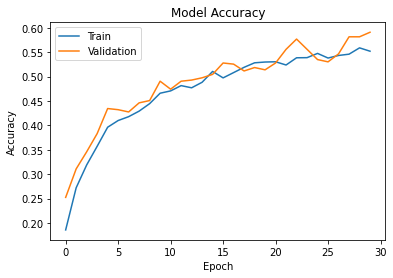

In [ ]:
plt.plot(vgg16_history.history['accuracy'])
plt.plot(vgg16_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Training and validation accuracy is very close, it doesn't overfit anymore but the accuracy of validation reached close to 60%. 

Let's check accuracy on Test data also.

In [ ]:
accuracy = xfer_model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 1s - loss: 1.2052 - accuracy: 0.5768 - 665ms/epoch - 44ms/step


It is 58% with above model, which is close to train and validation. 

Let's generate predictions using test data and create confusion matrix.

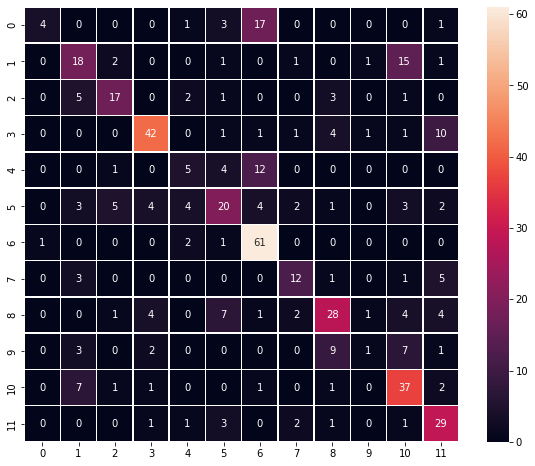

In [ ]:
# Here we would get the output as probablities for each category
y_pred=xfer_model1.predict(X_test_normalized)# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

Few observations - 

1) Many classes have identified correctly in this model. Misclassification has reduced. 

2) Misclassfication between 6 and 0, 1 and 10 and 11 and 3 is bit high. 


Let's check the other scores like recall, f1, preceision of each class by creating classification report. 

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_arg,y_pred_arg))

              precision    recall  f1-score   support

           0       0.80      0.15      0.26        26
           1       0.46      0.46      0.46        39
           2       0.63      0.59      0.61        29
           3       0.78      0.69      0.73        61
           4       0.33      0.23      0.27        22
           5       0.49      0.42      0.45        48
           6       0.63      0.94      0.75        65
           7       0.60      0.55      0.57        22
           8       0.58      0.54      0.56        52
           9       0.25      0.04      0.07        23
          10       0.53      0.74      0.62        50
          11       0.53      0.76      0.62        38

    accuracy                           0.58       475
   macro avg       0.55      0.51      0.50       475
weighted avg       0.57      0.58      0.55       475



As seen earlier, accuracy on test data is 58%. Class 3 has over all good scores in precision, recall and f1 scores. All classes have non-zero scores in this model.

##**Model 4 - Using Transfer Learning - VGG16 - 2**

In above VGG16 model, we just used all the layers (except classification) available for VGG16. I would like to try one more time with stopping layers at block3 and add some more layers of my own on top of it and see how it looks like. 

First clear the previous model's history from the session and fix the seed for same results.

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

Downloading VGG16 from Keras libraries. 

In [ ]:
# importing libraries
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16

# creating a model using VGG16, feeding the shape of input dataset and picking only the feature extraction layer and not the classification by setting include_top=false
model = VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

Let's take layers till block 3 only.

In [ ]:
# Getting only the conv layers for transfer learning.
transfer_layer = model.get_layer('block3_pool')
vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)

In [ ]:
# checking summary one more time to make sure it worked.
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

Looks good.

Freezing the layers so we don't train those again.

In [ ]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

Let's create a model with partial VGG model that created earlier and add couple of more conv and max pooling layers by keeping adam as optimizer. Also, keeping the same classification layers like before. 

In [ ]:
# Intializing a sequential model
xfer_model2 = Sequential()

# Adding the convolutional part of the VGG16 model from above
xfer_model2.add(vgg_model)
# Adding second conv layer with 32 filters and kernel size 3x3 , padding 'same'
xfer_model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
# Adding another max pooling layer
xfer_model2.add(MaxPooling2D((2, 2), padding = 'same'))
# Adding second conv layer with 16 filters and kernel size 3x3 , padding 'same'
xfer_model2.add(Conv2D(16, (3, 3), activation='relu', padding="same"))
# Adding another max pooling layer
xfer_model2.add(MaxPooling2D((2, 2), padding = 'same'))

# Flattening the output of the VGG16 model because it is from a convolutional layer
xfer_model2.add(Flatten())

# Adding a dense output layer
xfer_model2.add(Dense(64, activation='relu'))
# Adding dropout to randomly switch off 30% neurons to reduce overfitting
xfer_model2.add(Dropout(0.3))
xfer_model2.add(Dense(32, activation='relu'))
xfer_model2.add(Dense(12, activation='softmax'))

# Using Adam Optimizer
opt=Adam()
# Compile model
xfer_model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
xfer_model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 8, 8, 256)         1735488   
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 32)          73760     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 16)          4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 64)                0

Out of 1.8M, only 85K are trainable parameters. 

Let's fit the model by applying class weights that were calculated earlier and run for 30 epochs and batch size of 64. 

In [ ]:
# Epochs
epochs = 30
# Batch size
batch_size = 64

vgg16_history_2 = xfer_model2.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size, 
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)

Epoch 1/30
60/60 [==============================] - 18s 96ms/step - loss: 2.7278 - accuracy: 0.1295 - val_loss: 2.3337 - val_accuracy: 0.1846
Epoch 2/30
60/60 [==============================] - 5s 83ms/step - loss: 2.2501 - accuracy: 0.2257 - val_loss: 2.0337 - val_accuracy: 0.2850
Epoch 3/30
60/60 [==============================] - 6s 108ms/step - loss: 2.0055 - accuracy: 0.2982 - val_loss: 1.8174 - val_accuracy: 0.3294
Epoch 4/30
60/60 [==============================] - 5s 82ms/step - loss: 1.8127 - accuracy: 0.3674 - val_loss: 1.5920 - val_accuracy: 0.4533
Epoch 5/30
60/60 [==============================] - 5s 82ms/step - loss: 1.7208 - accuracy: 0.3992 - val_loss: 1.5349 - val_accuracy: 0.4603
Epoch 6/30
60/60 [==============================] - 5s 81ms/step - loss: 1.6017 - accuracy: 0.4269 - val_loss: 1.5289 - val_accuracy: 0.4556
Epoch 7/30
60/60 [==============================] - 5s 84ms/step - loss: 1.5388 - accuracy: 0.4502 - val_loss: 1.3501 - val_accuracy: 0.5234
Epoch 8/30


Let's build the accuracy graph by epochs

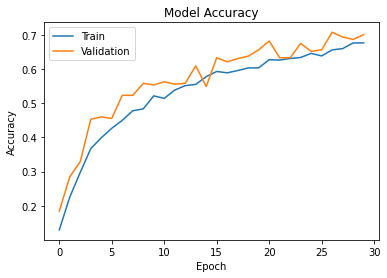

In [ ]:
plt.plot(vgg16_history_2.history['accuracy'])
plt.plot(vgg16_history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Looks much better. It doesn't overfit and train and validation data accuracy reached close to 70%.

Let's check accuracy on Test data also.

In [ ]:
accuracy = xfer_model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 1s - loss: 0.8644 - accuracy: 0.7137 - 529ms/epoch - 35ms/step


Test accuracy is 71%, it is much higher compare to previous model of all VGG16 and also its closer to what train and validation dataset gave. 

Let's generate predictions using test data and plot the confusion matrix.

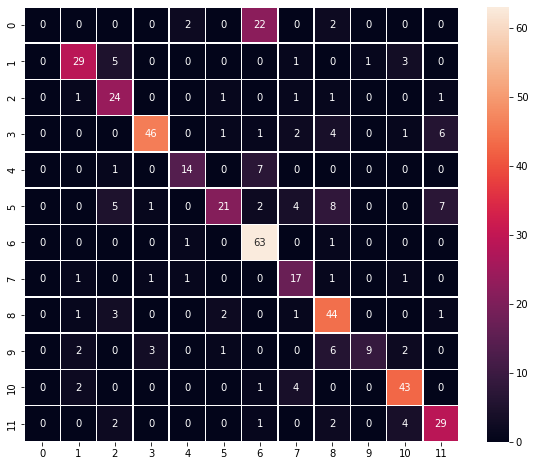

In [ ]:
# Here we would get the output as probablities for each category
y_pred=xfer_model2.predict(X_test_normalized)# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

Few observations - 

1) Almost all the classes were identified correctly with very less misclassification.

2) Misclassification of class 6 with class 0 is still there. 

3) Overall this confusion matrix looks the best so far. 

Let's check the other scores like recall, f1, preceision of each class by creating classification report. 


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_arg,y_pred_arg))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.81      0.74      0.77        39
           2       0.60      0.83      0.70        29
           3       0.90      0.75      0.82        61
           4       0.78      0.64      0.70        22
           5       0.81      0.44      0.57        48
           6       0.65      0.97      0.78        65
           7       0.57      0.77      0.65        22
           8       0.64      0.85      0.73        52
           9       0.90      0.39      0.55        23
          10       0.80      0.86      0.83        50
          11       0.66      0.76      0.71        38

    accuracy                           0.71       475
   macro avg       0.68      0.67      0.65       475
weighted avg       0.70      0.71      0.69       475



As seen earlier, accuracy on test data is 71%. Most of the classes very good precision, recall and f1 scores. 

##**Model 5 - Using Transfer Learning - ResNet50**

We tried transfer learning with VGG16 twice before, let's try with one more pre-made existing model (ResNet50) this time. Let's see if it give better results than VGG16.  

First clear the previous model's history from the session and fix the seed for same results.

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

Download ResNet50 from keras libraries.

In [ ]:
from tensorflow.keras.models import Model
from keras.applications.resnet import ResNet50

ResNet_model = ResNet50(weights='imagenet', include_top = False, input_shape = (64,64,3))
ResNet_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                          

It has more than 23M parameters and many more layers than VGG16. 

Let's freeze the layers as do not need to train them again.

In [ ]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in ResNet_model.layers:
    layer.trainable = False

Create a model by taking all layers of resnet without classification and add own layers and dropout. 

In [ ]:
# Intializing a sequential model
xfer_resnet_model = Sequential()

# Adding the convolutional part of the ResNet model from above
xfer_resnet_model.add(ResNet_model)

# Flattening the output of the ResNet model because it is from a convolutional layer
xfer_resnet_model.add(Flatten())

# Adding a dense output layer
xfer_resnet_model.add(Dense(32, activation='relu'))
# Adding dropout to randomly switch off 20% neurons to reduce overfitting
xfer_resnet_model.add(Dropout(0.2))
xfer_resnet_model.add(Dense(16, activation='relu'))
xfer_resnet_model.add(Dense(12, activation='softmax'))
opt=Adam()
# Compile model
xfer_resnet_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
xfer_resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 32)                262176    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 12)                204       
                                                                 
Total params: 23,850,620
Trainable params: 262,908
Non-t

Same like VGG16, there are very less parameters to train compare to total parameters.

Let's fit the model by applying class weights that were calculated earlier and run for 25 epochs and batch size of 64.

In [ ]:
# Epochs
epochs = 25
# Batch size
batch_size = 64

resnet50_history = xfer_resnet_model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size, 
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1,
                    class_weight=class_weights)

Epoch 1/25
60/60 [==============================] - 10s 111ms/step - loss: 2.8863 - accuracy: 0.1142 - val_loss: 2.4495 - val_accuracy: 0.1402
Epoch 2/25
60/60 [==============================] - 5s 84ms/step - loss: 2.8348 - accuracy: 0.1340 - val_loss: 2.4553 - val_accuracy: 0.1379
Epoch 3/25
60/60 [==============================] - 5s 83ms/step - loss: 2.8259 - accuracy: 0.1287 - val_loss: 2.4688 - val_accuracy: 0.1355
Epoch 4/25
60/60 [==============================] - 6s 108ms/step - loss: 2.8123 - accuracy: 0.1343 - val_loss: 2.4508 - val_accuracy: 0.1285
Epoch 5/25
60/60 [==============================] - 5s 84ms/step - loss: 2.8120 - accuracy: 0.1316 - val_loss: 2.4550 - val_accuracy: 0.1285
Epoch 6/25
60/60 [==============================] - 5s 85ms/step - loss: 2.8017 - accuracy: 0.1375 - val_loss: 2.4601 - val_accuracy: 0.1332
Epoch 7/25
60/60 [==============================] - 6s 93ms/step - loss: 2.7976 - accuracy: 0.1396 - val_loss: 2.4407 - val_accuracy: 0.1449
Epoch 8/25

Let's build the accuracy graph by epochs

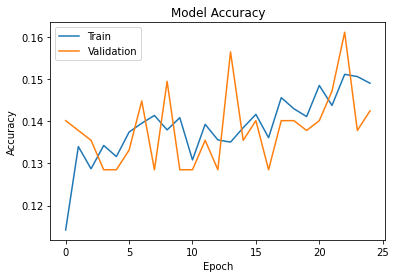

In [ ]:
plt.plot(resnet50_history.history['accuracy'])
plt.plot(resnet50_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Train and validation data accurarcy is very low

Let's check accuracy on Test data also. I guess it would be lower as well.

In [ ]:
accuracy = xfer_resnet_model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 1s - loss: 2.4476 - accuracy: 0.1516 - 735ms/epoch - 49ms/step


As expected, it is super low. 

Let's generate predictions using test data



In [ ]:
# Here we would get the output as probablities for each category
y_pred=xfer_resnet_model.predict(X_test_normalized)

Using y_pred values, we can plot the confusion matrix.

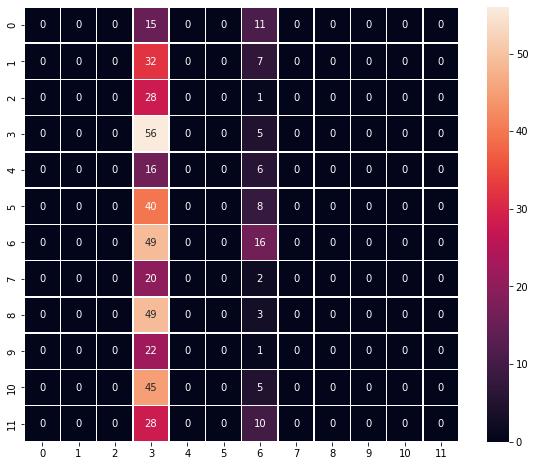

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

Looks really bad, class 3 is the most misclassified one. 

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_arg,y_pred_arg))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00        39
           2       0.00      0.00      0.00        29
           3       0.14      0.92      0.24        61
           4       0.00      0.00      0.00        22
           5       0.00      0.00      0.00        48
           6       0.21      0.25      0.23        65
           7       0.00      0.00      0.00        22
           8       0.00      0.00      0.00        52
           9       0.00      0.00      0.00        23
          10       0.00      0.00      0.00        50
          11       0.00      0.00      0.00        38

    accuracy                           0.15       475
   macro avg       0.03      0.10      0.04       475
weighted avg       0.05      0.15      0.06       475



Very poor accuracy and all other metrics. I do not think there is a point in trying to improve this one.

We have created enough models, now lets's compare those. 

# **6. Model Comparison**

As part of this project, we tried 5 different models. Here is the comparison of all those based on their accuracy on train, validation and test data.  

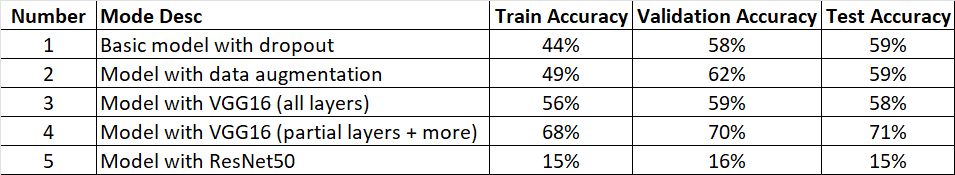

By looking at accuracy in all train, test and validation, model # 4 (partial VGG + some more custom layers) performed the best. It has VGG layers till block 3, two more conv and max polling layers after that. Also, in classification layer, applied droputout of 30% after the first layer. The model didn't overfit and provided more than 70% accuracy in the test dataset. I would choose that over any other. 

# **7. Conclusion and Key Takeaways**

As part of this project, we have analyzed the dataset of different plant species using Convolutional Neural Network models that classified the plant seedlings into their respective 12 categories. 

To achieve the goal, we tried different Convolutional Neural Network models based on different kind of regularization and transfer learning techniques and determined the best model. 

While doing EDA and other part of the project, few key takeaways can be mentioned - 


*   The images dataset is imbalanced, the number of images by class vary a lot. Needed to find the weights and applied to make it balanced. 

*   Size of images could be reduced for faster computation and we were able to blur it using gaussian blurring to reduce the noise. 

*   The best accuracy we found on test data was 71% which is ok but still have lot of scope of improvement. 

Few suggestions to improve further -

* To start with, we have got dataset wtih less images, less than 5K. If we get more images on these species would help train the model better. We tried data augmentation, but it was not enough.

*   All models were tried with Adam optimizer to update weights during training, it is usually the most effective one, can be tried with other optimizers and their learning rate.

*   We can try to improve by changing the filter size and number of filters. Also, it can be trained with original size of the images rather than reduced size and blurred images. It would take lot more computation but if it increases the accuracy drastically then probably would be worth it.  

*   Try with different dropout values and after different layers to see if that helps. 

* We tried with VGG16 and ResNet50, but can be tried with other transfer learning architectures also. 


